In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import yfinance as yf
from yahooquery import Ticker
from yahooquery import Screener
# import plotly.graph_objects as go

from sklearn.model_selection import TimeSeriesSplit  # you have everything done for you
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.core.window import Rolling
import statsmodels.api as sm 

from pmdarima.arima import auto_arima
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima

In [3]:
# spy_ohlc_df = yf.download('SPY', start='1995-01-02', end='2023-04-01')
# dow_jones_ohlc_df = yf.download('DJI', start='1995-01-02', end='2023-04-01')
# nasdaq_ohlc_df = yf.download('NDX', start='1995-01-02', end='2023-04-01')

# spy_ohlc_df.to_csv('./data/spy_ohlc_df.csv')
# dow_jones_ohlc_df.to_csv('./data/dow_jones_ohlc_df.csv')
# nasdaq_ohlc_df.to_csv('./data/nasdaq_ohlc_df.csv')

In [6]:
class CFG:
    data_path = "../data"
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024


# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   


def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(CFG.seed)

In [7]:
spy_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'spy_ohlc_df.csv')
dow_jones_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'dow_jones_ohlc_df.csv')
nasdaq_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'nasdaq_ohlc_df.csv')

In [4]:
spy_ohlc_df.isnull().values.any(), dow_jones_ohlc_df.isnull().values.any(), 

(False, False)

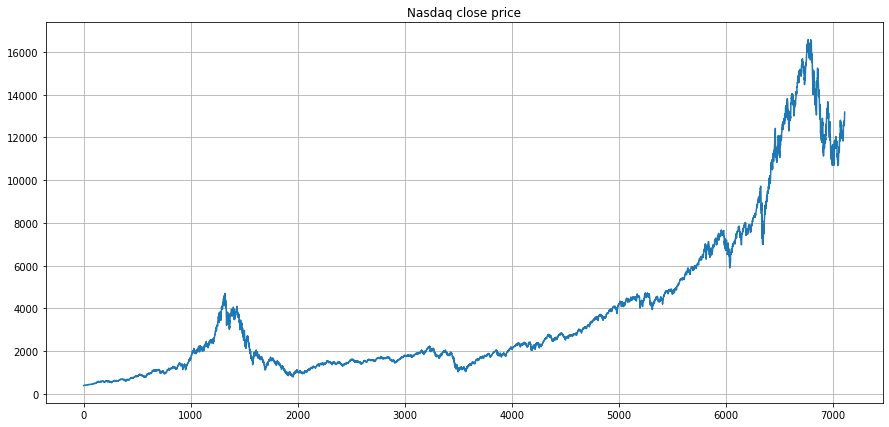

In [5]:
plt.figure(figsize=(15, 7))
plt.plot(nasdaq_ohlc_df.Close)
plt.title('Nasdaq close price')
plt.grid(True)
plt.show()

In [6]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])


def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(20,8))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  

        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=slen,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

NameError: name 'mean_squared_error' is not defined

In [ ]:
def test_stationarity(timeseries, window_size=250):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window_size).mean()
    rolstd = timeseries.rolling(window_size).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
        
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

In [ ]:
# moving_average(nasdaq_ohlc_df.Close, 24)

In [ ]:
# plotMovingAverage(nasdaq_ohlc_df[['Close']][-500:], 4)

In [ ]:
# plotMovingAverage(nasdaq_ohlc_df[['Close']][-100:], 4, plot_intervals=True)

In [ ]:
# plotMovingAverage(nasdaq_ohlc_df[['Close']][-30:], 7, plot_intervals=True, plot_anomalies=True)

In [ ]:
nasdaq_decomposition = seasonal_decompose(nasdaq_ohlc_df.Close, period=250)
spy_decomposition = seasonal_decompose(spy_ohlc_df.Close, period=250)
dow_jones_decomposition = seasonal_decompose(dow_jones_ohlc_df.Close, period=250)

<Figure size 1440x720 with 0 Axes>

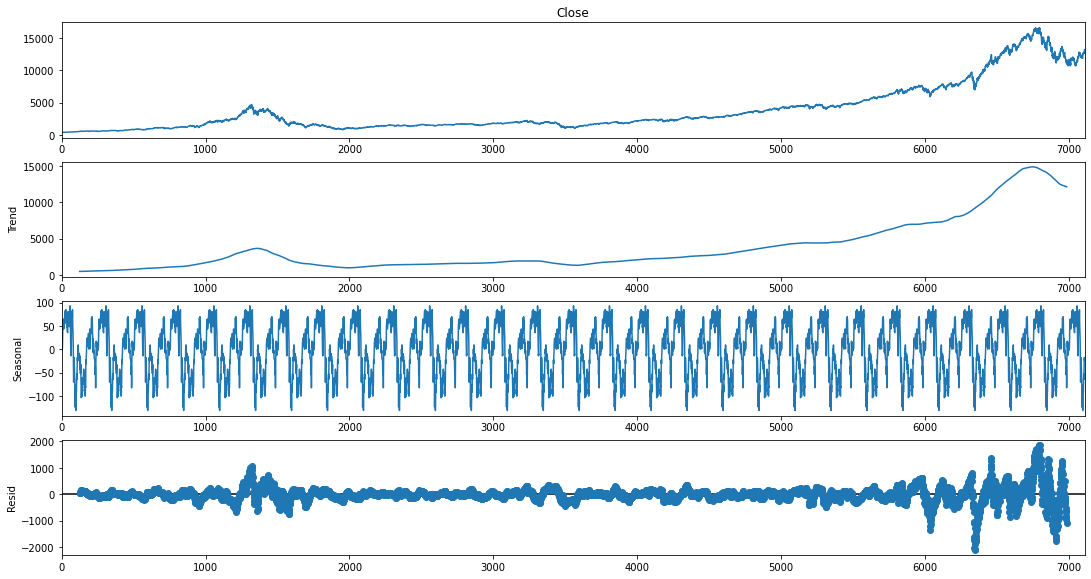

In [ ]:
fig = plt.figure()  
fig = nasdaq_decomposition.plot()
fig.set_size_inches(15, 8)

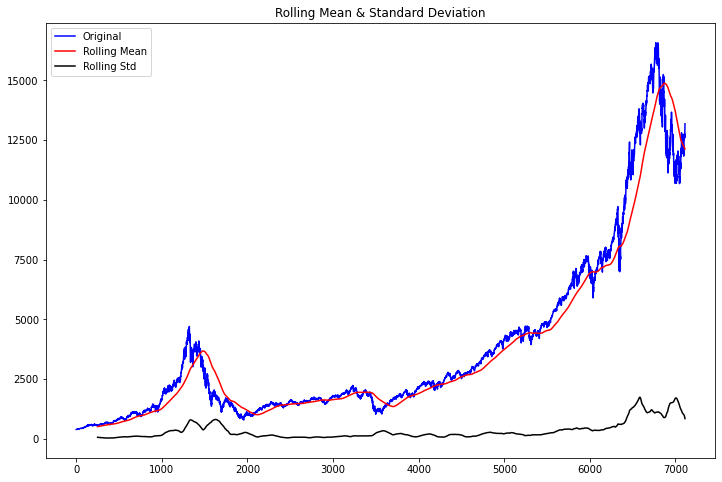

Results of Dickey-Fuller Test:
Non-stationary
Test Statistic                    1.021907
p-value                           0.994492
#Lags Used                       28.000000
Number of Observations Used    7083.000000
Critical Value (1%)              -3.431274
Critical Value (5%)              -2.861948
Critical Value (10%)             -2.566987
dtype: float64


In [143]:
test_stationarity(nasdaq_ohlc_df.Close)

C:\ML\kaggle\kaggle_competition\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


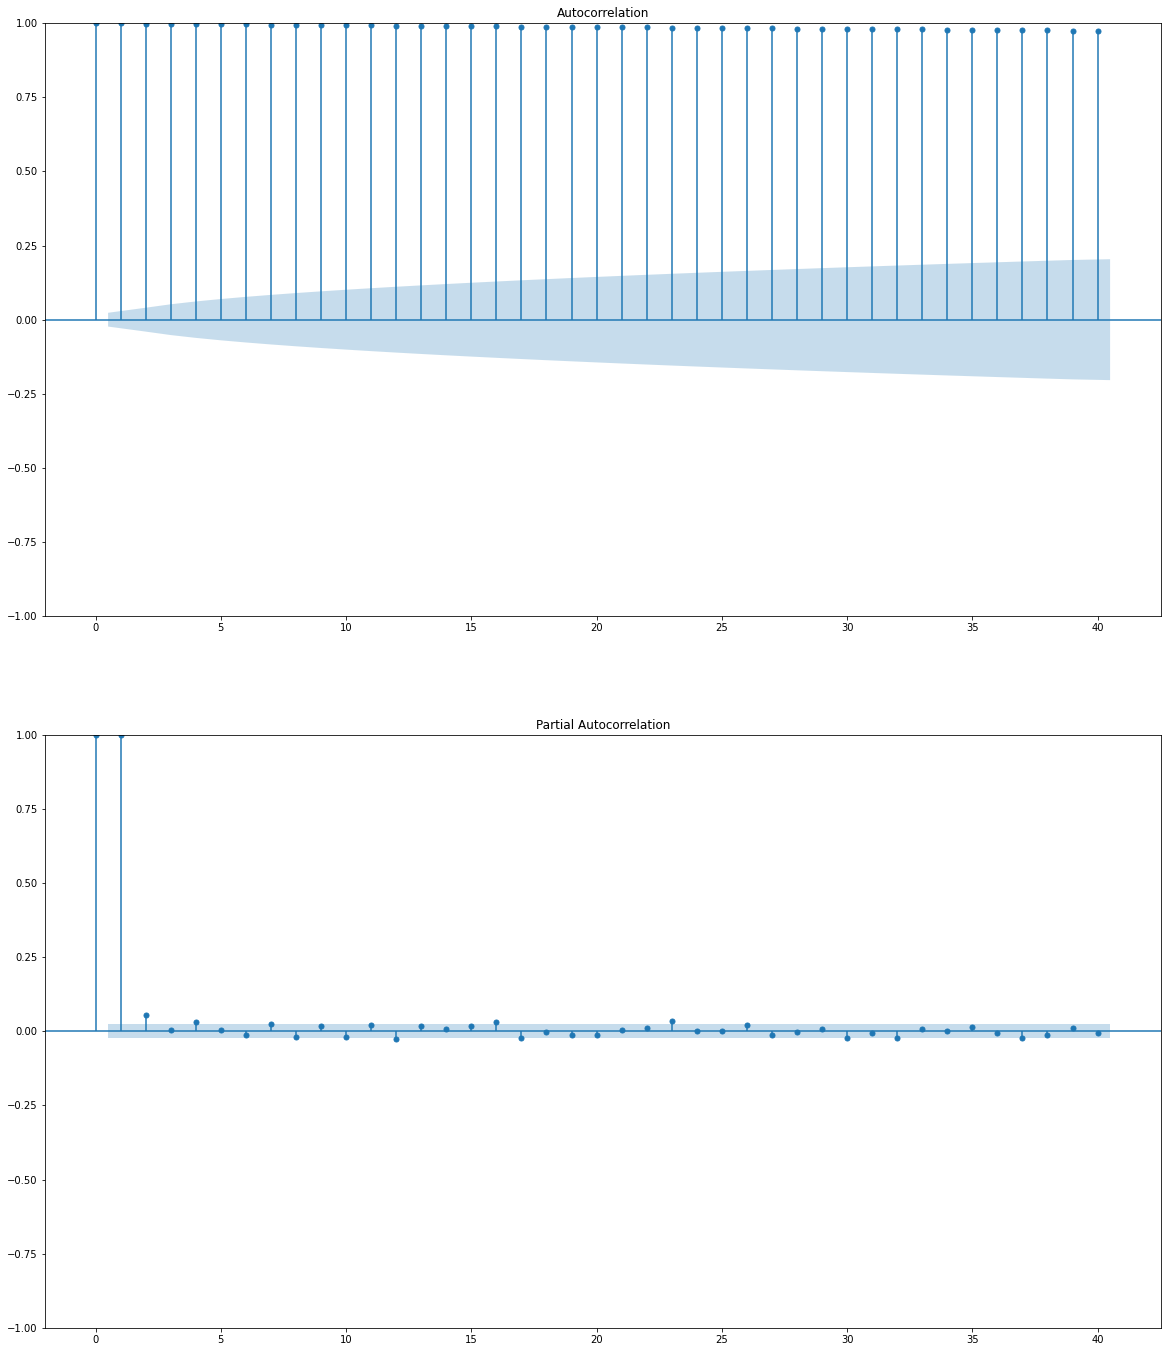

In [147]:
fig = plt.figure(figsize=(20,24))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(nasdaq_ohlc_df.Close, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(nasdaq_ohlc_df.Close, lags=40, ax=ax2)

In [7]:
# fig = plt.figure()  
# fig = spy_decomposition.plot()
# fig.set_size_inches(15, 8)

In [8]:
# test_stationarity(spy_ohlc_df.Close)

In [9]:
# fig = plt.figure()  
# fig = dow_jones_decomposition.plot()
# fig.set_size_inches(15, 8)

In [10]:
# test_stationarity(dow_jones_ohlc_df.Close)

<h5>So now we need to transform the data to make it more stationary. There are various transformations you can do to stationarize the data.</h5>

- Deflation by CPI
- Logarithmic
- First Difference
- Seasonal Difference
- Seasonal Adjustment

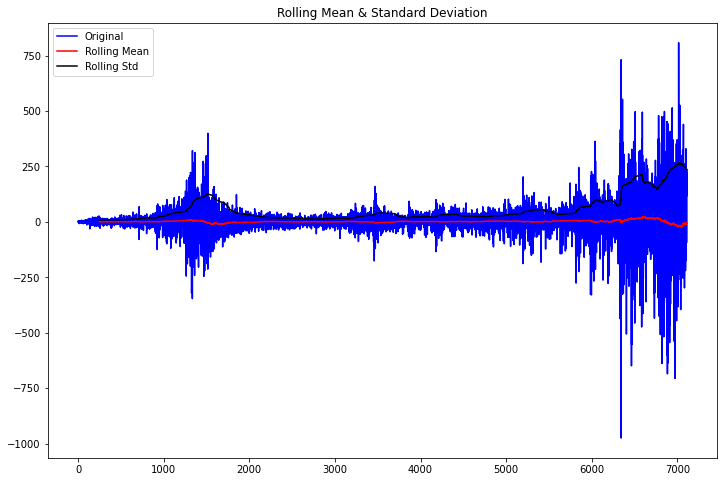

Results of Dickey-Fuller Test:
Stationary
Test Statistic                -1.416222e+01
p-value                        2.071442e-26
#Lags Used                     3.500000e+01
Number of Observations Used    7.075000e+03
Critical Value (1%)           -3.431275e+00
Critical Value (5%)           -2.861949e+00
Critical Value (10%)          -2.566987e+00
dtype: float64


In [148]:
nasdaq_ohlc_df['first_difference_Close'] = nasdaq_ohlc_df.Close - nasdaq_ohlc_df.Close.shift(1)
test_stationarity(nasdaq_ohlc_df.first_difference_Close.dropna(inplace=False))

C:\ML\kaggle\kaggle_competition\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


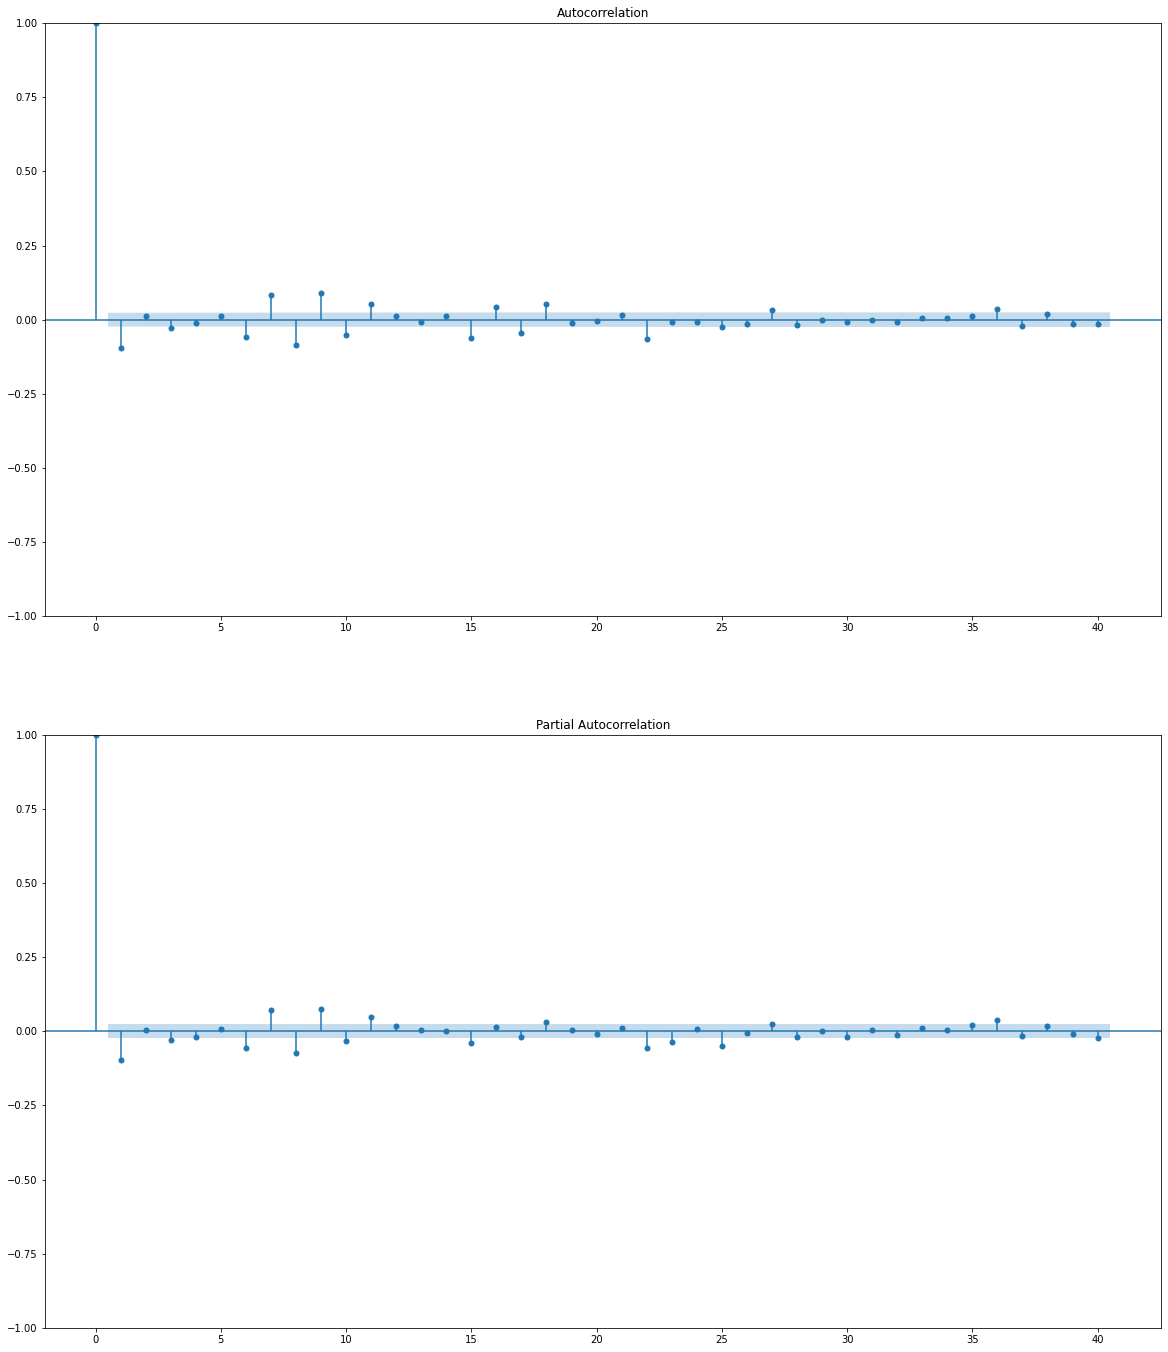

In [151]:
fig = plt.figure(figsize=(20,24))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(nasdaq_ohlc_df.first_difference_Close.iloc[1:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(nasdaq_ohlc_df.first_difference_Close.iloc[1:], lags=40, ax=ax2)

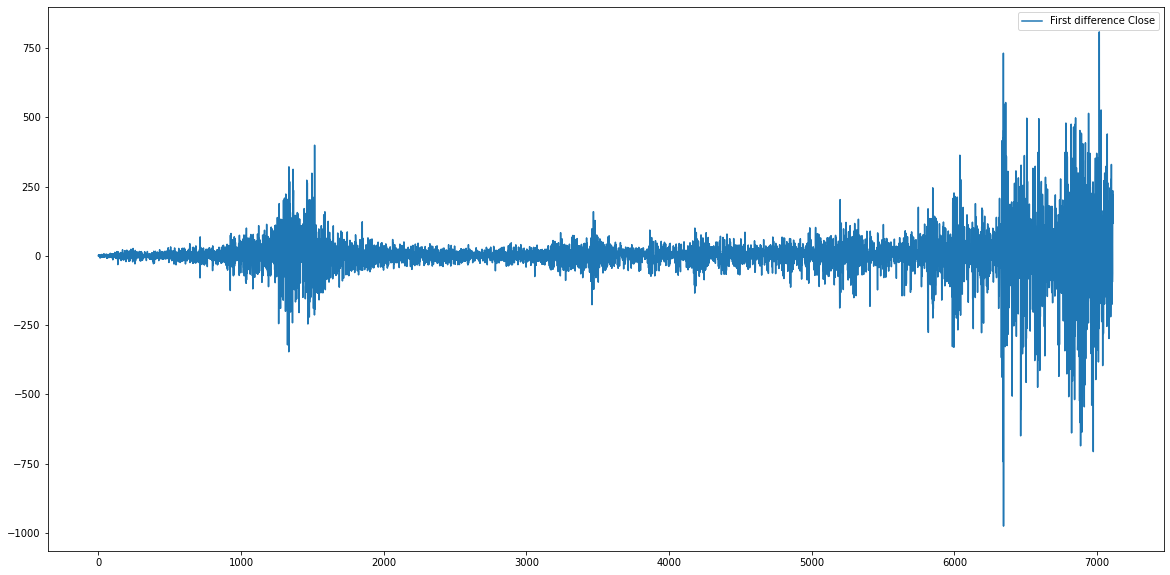

In [153]:
plt.plot(nasdaq_ohlc_df.first_difference_Close, label = 'First difference Close')
plt.ylabel('')
plt.legend()
plt.show()

In [12]:
nasdaq_ohlc_df['seasonal_difference_Close'] = nasdaq_ohlc_df.Close - nasdaq_ohlc_df.Close.shift(250)
test_stationarity(nasdaq_ohlc_df.seasonal_difference_Close.dropna(inplace=False))

NameError: name 'test_stationarity' is not defined

In [13]:
nasdaq_ohlc_df['seasonal_first_difference_Close'] = nasdaq_ohlc_df.first_difference_Close - nasdaq_ohlc_df.first_difference_Close.shift(250)
test_stationarity(nasdaq_ohlc_df.seasonal_first_difference_Close.dropna(inplace=False))

NameError: name 'test_stationarity' is not defined

In [ ]:
lag_features = ["High", "Low", "Close"]
window_size = 250

df = nasdaq_ohlc_df[-1000:].copy()

df_rolled = df[lag_features].rolling(window = window_size, min_periods=0)
df_mean = df_rolled.mean().shift(1).reset_index()
df_std = df_rolled.std().shift(1).reset_index()

for feature in lag_features:
    df[feature + '_mean_lag' + str(window_size)] = df_mean[feature].values
    df[feature + '_std_lag' + str(window_size)] = df_std[feature].values

# Prophet can handle missing values, but ARIMA cannot
df.fillna(df.mean(), inplace=True)

C:\Users\HP\AppData\Local\Temp/ipykernel_23600/1223518364.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace=True)


In [104]:
train_size = int(len(df) * 0.9)

In [154]:
nasdaq_ohlc_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'first_difference_Close'],
      dtype='object')

In [38]:
Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')

Y_df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


In [47]:
from statsforecast import StatsForecast

sf = StatsForecast()

sf.plot(Y_df)

TypeError: __init__() missing 2 required positional arguments: 'models' and 'freq'

In [8]:
df_fb = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df_fb.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [22]:
from prophet import Prophet



m = Prophet(daily_seasonality=False)
m.fit(df_fb)
future = m.make_future_dataframe(365)
forecast = m.predict(future)

2023-05-09 17:34:39 cmdstanpy DEBUG: cmd: where.exe tbb.dll
cwd: None
2023-05-09 17:34:39 cmdstanpy DEBUG: TBB already found in load path
2023-05-09 17:34:39 cmdstanpy DEBUG: input tempfile: C:\Users\HP\AppData\Local\Temp\tmpkxcxiinn\qlbv_fct.json
2023-05-09 17:34:40 cmdstanpy DEBUG: input tempfile: C:\Users\HP\AppData\Local\Temp\tmpkxcxiinn\4tkf7hn_.json
2023-05-09 17:34:40 cmdstanpy DEBUG: idx 0
2023-05-09 17:34:40 cmdstanpy DEBUG: running CmdStan, num_threads: None
2023-05-09 17:34:40 cmdstanpy DEBUG: CmdStan args: ['C:\\ML\\kaggle\\kaggle_competition\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=85481', 'data', 'file=C:\\Users\\HP\\AppData\\Local\\Temp\\tmpkxcxiinn\\qlbv_fct.json', 'init=C:\\Users\\HP\\AppData\\Local\\Temp\\tmpkxcxiinn\\4tkf7hn_.json', 'output', 'file=C:\\Users\\HP\\AppData\\Local\\Temp\\tmpkxcxiinn\\prophet_modely4m86563\\prophet_model-20230509173440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:40 - cmdstanpy - IN

In [35]:
np.array(forecast)[:, 1:]

array([[8.039712597726297, 8.189096539536328, 9.441365617635537, ...,
        0.0, 0.0, 8.842664005355411],
       [8.03818551277128, 7.960458318341448, 9.153960976440873, ..., 0.0,
        0.0, 8.591244566969408],
       [8.036658427816263, 7.7645836091402165, 9.011009782675634, ...,
        0.0, 0.0, 8.387084863214334],
       ...,
       [7.184202216653455, 7.56127178502699, 9.036082008461216, ..., 0.0,
        0.0, 8.316651496126534],
       [7.183172441232897, 7.46414434912104, 8.874088088730334, ..., 0.0,
        0.0, 8.149239285664654],
       [7.182142665812339, 7.40869834035595, 8.883331686133292, ..., 0.0,
        0.0, 8.16115071434736]], dtype=object)

In [36]:
np.array(forecast)[:, :]

array([[Timestamp('2007-12-10 00:00:00'), 8.039712597726297,
        8.189096539536328, ..., 0.0, 0.0, 8.842664005355411],
       [Timestamp('2007-12-11 00:00:00'), 8.03818551277128,
        7.960458318341448, ..., 0.0, 0.0, 8.591244566969408],
       [Timestamp('2007-12-12 00:00:00'), 8.036658427816263,
        7.7645836091402165, ..., 0.0, 0.0, 8.387084863214334],
       ...,
       [Timestamp('2017-01-17 00:00:00'), 7.184202216653455,
        7.56127178502699, ..., 0.0, 0.0, 8.316651496126534],
       [Timestamp('2017-01-18 00:00:00'), 7.183172441232897,
        7.46414434912104, ..., 0.0, 0.0, 8.149239285664654],
       [Timestamp('2017-01-19 00:00:00'), 7.182142665812339,
        7.40869834035595, ..., 0.0, 0.0, 8.16115071434736]], dtype=object)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

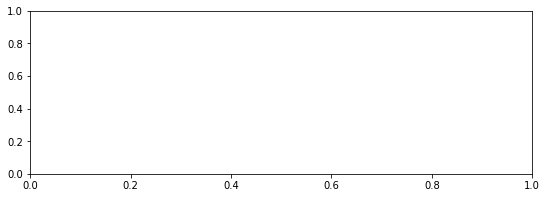

In [37]:
fig2 = m.plot_components(np.array(forecast)[:, 1:])

In [12]:
from statsforecast.adapters.prophet import AutoARIMAProphet

m = AutoARIMAProphet(daily_seasonality=False)

m.fit(df_fb)
# m.fit(df, disable_seasonal_features=False) # Uncomment for better AutoARIMA predictions
future = m.make_future_dataframe(365)
forecast = m.predict(future)


2023-05-09 17:30:38 cmdstanpy DEBUG: cmd: where.exe tbb.dll
cwd: None
2023-05-09 17:30:39 cmdstanpy DEBUG: TBB already found in load path
C:\ML\kaggle\kaggle_competition\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ML\kaggle\kaggle_competition\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ML\kaggle\kaggle_competition\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ML\kaggle\kaggle_competition\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ML\kaggle\kaggle_competition\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ML\kaggle\kaggle_competition\lib\site-packages\scipy\optimize\_numdiff.py:557: Runti

TypeError: concat() takes 1 positional argument but 2 were given

In [ ]:
fig = m.plot(forecast)

In [106]:
# prepare the training / validation split
# df_train = df[df.Date < "2023"]
# df_valid = df[df.Date >= "2023"]
df_train = df.iloc[:train_size]
df_valid = df.iloc[train_size:]

exogenous_features = ['High_mean_lag'+str(window_size), 
                      'High_std_lag'+str(window_size), 
                      'Low_mean_lag'+str(window_size),
                      'Low_std_lag'+str(window_size), 
                      'Close_mean_lag'+str(window_size), 
                      'Close_std_lag'+str(window_size)]

In [107]:
df_valid

,Date,Open,High,Low,Close,Adj Close,Volume,first_difference_Close,seasonal_difference,seasonal_difference_Close,seasonal_first_difference_Close,High_mean_lag250,High_std_lag250,Low_mean_lag250,Low_std_lag250,Close_mean_lag250,Close_std_lag250
7012,2022-11-07,10900.830078,11001.160156,10817.589844,10977.000000,10977.000000,4456690000,119.969727,-5242.940430,-5242.940430,236.059570,13610.868195,1703.083109,13302.958844,1703.400796,13455.495852,1706.767851
7013,2022-11-08,11039.580078,11191.900391,10897.530273,11059.500000,11059.500000,5134500000,82.500000,-4926.070312,-4926.070312,316.870117,13589.265273,1701.790488,13281.554684,1700.864943,13434.524090,1704.873598
7014,2022-11-09,10971.429688,11012.660156,10790.349609,10797.549805,10797.549805,4977460000,-261.950195,-5234.919922,-5234.919922,-308.849609,13569.134836,1700.257672,13261.523684,1699.328681,13414.819809,1703.737611
7015,2022-11-10,11350.419922,11612.200195,11235.740234,11605.959961,11605.959961,6433000000,808.410156,-4593.929688,-4593.929688,640.990234,13548.720477,1700.191039,13240.607523,1697.426920,13393.880129,1703.606066
7016,2022-11-11,11604.360352,11840.070312,11535.559570,11817.009766,11817.009766,5867750000,211.049805,-4372.110352,-4372.110352,221.819336,13530.295078,1696.096381,13221.499363,1692.976929,13375.504410,1697.984496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7107,2023-03-27,12797.900391,12839.419922,12647.940430,12673.070312,12673.070312,4330320000,-93.979492,-2314.330078,-2314.330078,-327.070312,12305.860836,943.162716,12037.491957,931.867146,12173.997875,937.533607
7108,2023-03-28,12654.910156,12654.910156,12517.870117,12610.570312,12610.570312,4036910000,-62.500000,-2628.750000,-2628.750000,-314.419922,12297.262195,928.283723,12029.260039,917.174192,12164.740555,920.920968
7109,2023-03-29,12768.139648,12867.320312,12734.679688,12846.030273,12846.030273,4493540000,235.459961,-2225.519531,-2225.519531,403.230469,12286.820156,909.248883,12019.173078,897.591625,12154.225555,900.454691
7110,2023-03-30,12934.990234,12987.969727,12894.139648,12963.139648,12963.139648,4738880000,117.109375,-1875.350586,-1875.350586,350.168945,12277.373398,890.635890,12010.070438,878.471123,12145.323477,882.315877


In [108]:
model_arima = auto_arima(df_train.Close, 
                          exogenous=df_train[exogenous_features], 
                          m = 1,  
                          # max ranges for the p,q,P,Q parameters - can be extended
                          # max_p= 3, max_q=3,    
                          # max_P=3, max_Q=3,
                          trace=True, 
                          error_action="ignore", suppress_warnings=True)
model_arima.fit(df_train.Close, exogenous=df_train[exogenous_features])

forecast = model_arima.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12025.804, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12032.887, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12021.523, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12022.539, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12031.194, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12022.166, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12021.833, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12021.871, Time=1.00 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12019.916, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=12020.527, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12020.180, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12020.935, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=12020.282, Time=0.31 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.507 seconds


C:\Users\HP\AppData\Local\Temp/ipykernel_23600/1221257592.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Forecast_ARIMAX"] = forecast


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  900
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -6007.958
Date:                Sat, 29 Apr 2023   AIC                          12019.916
Time:                        14:19:51   BIC                          12029.519
Sample:                             0   HQIC                         12023.584
                                - 900                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1209      0.025     -4.923      0.000      -0.169      -0.073
sigma2      3.739e+04   1333.313     28.040      0.000    3.48e+04       4e+04
Ljung-Box (L1) (Q):                   0.01   Jarque-

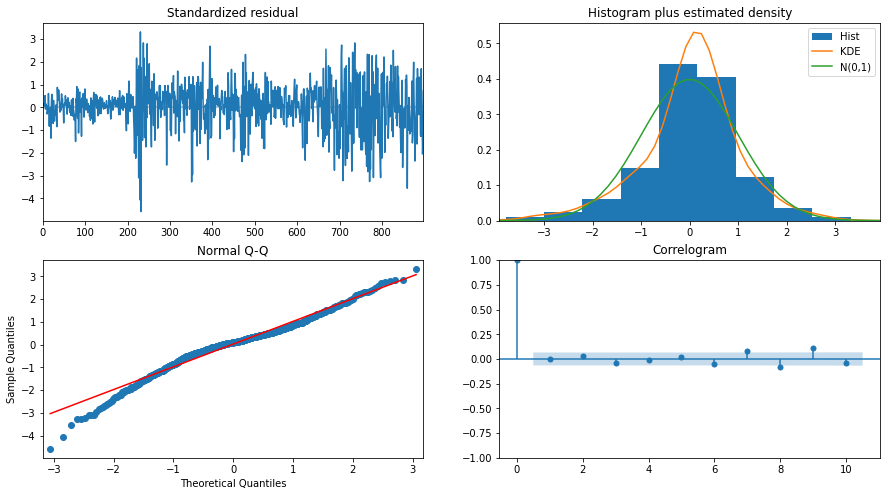

In [109]:
print(model_arima.summary())
model_arima.plot_diagnostics(figsize=(15,8))
plt.show()

In [110]:
# # Forecast
# fc, se, conf = model_arima.forecast(321, alpha=0.05)  # 95% conf
# # Make as pandas series
# fc_series = pd.Series(fc, index=df_valid.index)
# lower_series = pd.Series(conf[:, 0], index=df_valid.index)
# upper_series = pd.Series(conf[:, 1], index=df_valid.index)
# # Plot
# plt.figure(figsize=(10,5), dpi=100)
# plt.plot(df_train, label='training data')
# plt.plot(df_valid, color = 'blue', label='Actual Stock Price')
# plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.10)
# plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('ARCH CAPITAL GROUP Stock Price')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()


In [112]:
df_valid

,Date,Open,High,Low,Close,Adj Close,Volume,first_difference_Close,seasonal_difference,seasonal_difference_Close,seasonal_first_difference_Close,High_mean_lag250,High_std_lag250,Low_mean_lag250,Low_std_lag250,Close_mean_lag250,Close_std_lag250,Forecast_ARIMAX
7012,2022-11-07,10900.830078,11001.160156,10817.589844,10977.000000,10977.000000,4456690000,119.969727,-5242.940430,-5242.940430,236.059570,13610.868195,1703.083109,13302.958844,1703.400796,13455.495852,1706.767851,10836.905384
7013,2022-11-08,11039.580078,11191.900391,10897.530273,11059.500000,11059.500000,5134500000,82.500000,-4926.070312,-4926.070312,316.870117,13589.265273,1701.790488,13281.554684,1700.864943,13434.524090,1704.873598,10839.338897
7014,2022-11-09,10971.429688,11012.660156,10790.349609,10797.549805,10797.549805,4977460000,-261.950195,-5234.919922,-5234.919922,-308.849609,13569.134836,1700.257672,13261.523684,1699.328681,13414.819809,1703.737611,10839.044635
7015,2022-11-10,11350.419922,11612.200195,11235.740234,11605.959961,11605.959961,6433000000,808.410156,-4593.929688,-4593.929688,640.990234,13548.720477,1700.191039,13240.607523,1697.426920,13393.880129,1703.606066,10839.080217
7016,2022-11-11,11604.360352,11840.070312,11535.559570,11817.009766,11817.009766,5867750000,211.049805,-4372.110352,-4372.110352,221.819336,13530.295078,1696.096381,13221.499363,1692.976929,13375.504410,1697.984496,10839.075915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7107,2023-03-27,12797.900391,12839.419922,12647.940430,12673.070312,12673.070312,4330320000,-93.979492,-2314.330078,-2314.330078,-327.070312,12305.860836,943.162716,12037.491957,931.867146,12173.997875,937.533607,10839.076379
7108,2023-03-28,12654.910156,12654.910156,12517.870117,12610.570312,12610.570312,4036910000,-62.500000,-2628.750000,-2628.750000,-314.419922,12297.262195,928.283723,12029.260039,917.174192,12164.740555,920.920968,10839.076379
7109,2023-03-29,12768.139648,12867.320312,12734.679688,12846.030273,12846.030273,4493540000,235.459961,-2225.519531,-2225.519531,403.230469,12286.820156,909.248883,12019.173078,897.591625,12154.225555,900.454691,10839.076379
7110,2023-03-30,12934.990234,12987.969727,12894.139648,12963.139648,12963.139648,4738880000,117.109375,-1875.350586,-1875.350586,350.168945,12277.373398,890.635890,12010.070438,878.471123,12145.323477,882.315877,10839.076379


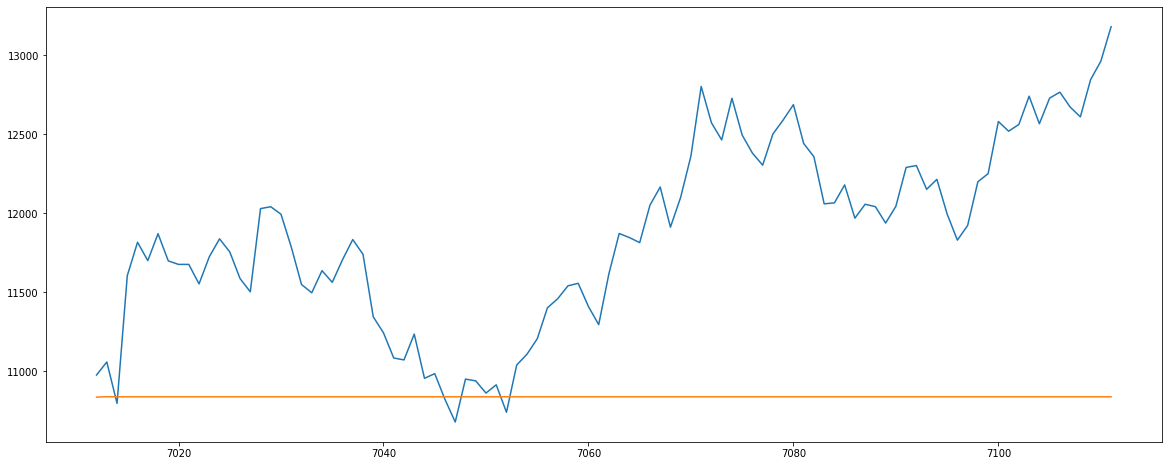

In [111]:
plt.figure(figsize=(20, 8))

plt.plot(df_valid.Close)
plt.plot(df_valid.Forecast_ARIMAX)
plt.show()

In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(df_valid.Close, df_valid.Forecast_ARIMAX))
print('RMSE:', rmse)

RMSE: 20385.10298709532


# RNN

In [22]:
import random 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import GroupKFold

from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_squared_error as mse


In [23]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

def create_dataset(df, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back -look_ahead):
        xdat.append(df[i:i+ look_back ,0])
        ydat.append(df[i+ look_back : i + look_back + look_ahead,0])
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1,look_ahead)
    return xdat, ydat

In [24]:
def prepare_split(xdat, ydat, cutoff = 5000, timesteps = 50):
    xtrain, xvalid = xdat[:cutoff,:], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff,:], ydat[cutoff:,]

    # reshape into [batch size, time steps, dimensionality]
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1)

    return xtrain, ytrain, xvalid, yvalid

In [137]:
def make_df_from(df):
  df_out = df[['Date', 'Close']].copy()
  df_out['Date'] = pd.to_datetime(df_out['Date'])
  df_out.set_index('Date', inplace=True)
  return df_out

In [139]:
df_rnn_spy = make_df_from(spy_ohlc_df)
df_rnn_dow = make_df_from(dow_jones_ohlc_df)

In [86]:
df_rnn = nasdaq_ohlc_df[['Date', 'Close']].copy()
df_rnn['Date'] = pd.to_datetime(df_rnn['Date'])
df_rnn.set_index('Date', inplace=True)
df_rnn.head()

,Close
Date,
1995-01-03,398.000000
1995-01-04,399.649994
1995-01-05,398.019989
1995-01-06,401.589996
1995-01-09,403.529999


In [87]:
# df_rnn.Close.plot(xlabel = '')

In [88]:
scaler = MinMaxScaler()
df_rnn = scaler.fit_transform(df_rnn)

In [89]:
# use 50 historical observations, predict 1 step ahead
look_back = 50
look_ahead = 1

xdat, ydat = create_dataset(df_rnn, look_back = look_back, look_ahead = look_ahead)

# We only want to forecast a single value for each series => target is a column
print(xdat.shape, ydat.shape)

(7061, 50) (7061, 1)


In [90]:
xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps = look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)

(5000, 50, 1) (2061, 50, 1) (5000, 1) (2061, 1)


In [91]:
def create_model1():    
    
    model=Sequential()
    model.add(SimpleRNN(10, input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model1 = create_model1()

In [92]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [32]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

model1.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

Epoch 1/6
313/313 [==============================] - 4s 11ms/step - loss: 0.0103 - val_loss: 0.9397
Epoch 2/6
313/313 [==============================] - 3s 10ms/step - loss: 5.3536e-04 - val_loss: 0.8091
Epoch 3/6
313/313 [==============================] - 4s 12ms/step - loss: 2.5460e-04 - val_loss: 0.7345
Epoch 4/6
313/313 [==============================] - 3s 11ms/step - loss: 1.9889e-04 - val_loss: 0.6746
Epoch 5/6
313/313 [==============================] - 3s 10ms/step - loss: 1.7023e-04 - val_loss: 0.6196
Epoch 6/6
313/313 [==============================] - 3s 11ms/step - loss: 1.5591e-04 - val_loss: 0.5526


In [52]:
# predict and calculate RMSE
y_pred1 = model1.predict(xvalid)
y_pred1 = scaler.inverse_transform(y_pred1)
yvalid1 =  scaler.inverse_transform(yvalid)

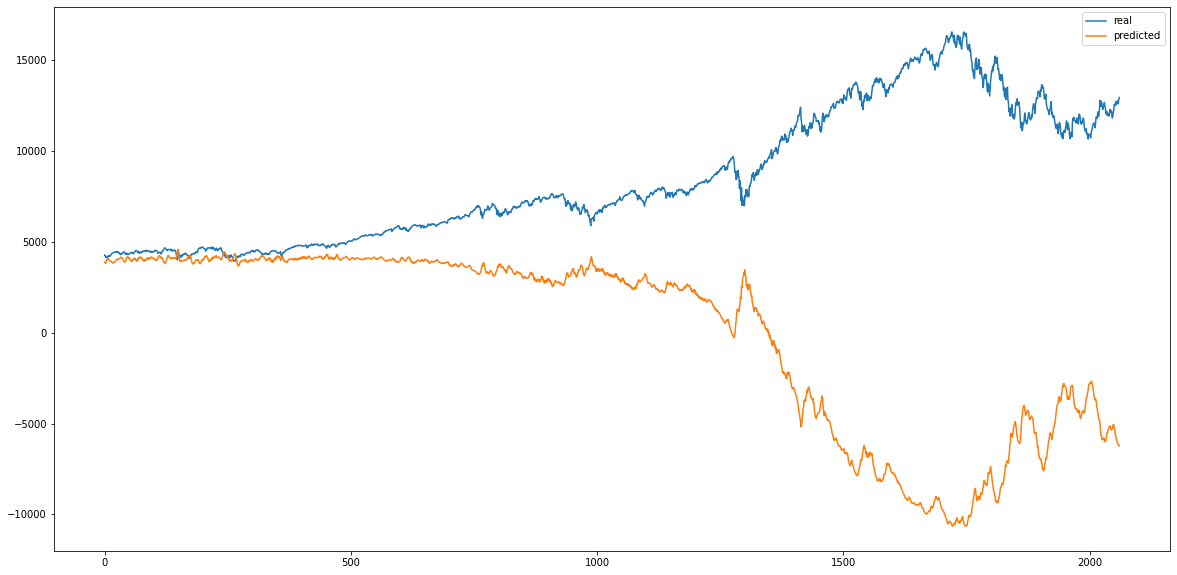

In [53]:
plt.plot(yvalid1, label = 'real')
plt.plot(y_pred1, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

In [46]:
def create_model2():    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model2 = create_model2()
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 10)          120       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [47]:
model2.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred2 = model2.predict(xvalid)
y_pred2 = scaler.inverse_transform(y_pred2)
print('RMSE: ' + str(my_rmse(y_pred2, scaler.inverse_transform(yvalid))))

Epoch 1/6
313/313 [==============================] - 8s 20ms/step - loss: 4.1918e-04 - val_loss: 0.0855
Epoch 2/6
313/313 [==============================] - 5s 17ms/step - loss: 8.4944e-05 - val_loss: 0.0700
Epoch 3/6
313/313 [==============================] - 5s 17ms/step - loss: 5.7648e-05 - val_loss: 0.0597
Epoch 4/6
313/313 [==============================] - 5s 15ms/step - loss: 4.4751e-05 - val_loss: 0.0524
Epoch 5/6
313/313 [==============================] - 6s 19ms/step - loss: 3.5710e-05 - val_loss: 0.0451
Epoch 6/6
313/313 [==============================] - 7s 21ms/step - loss: 3.5560e-05 - val_loss: 0.0406
RMSE: 3258.7694


In [48]:
# predict and calculate RMSE
y_pred2 = model2.predict(xvalid)
y_pred2 = scaler.inverse_transform(y_pred2)
yvalid2 =  scaler.inverse_transform(yvalid)

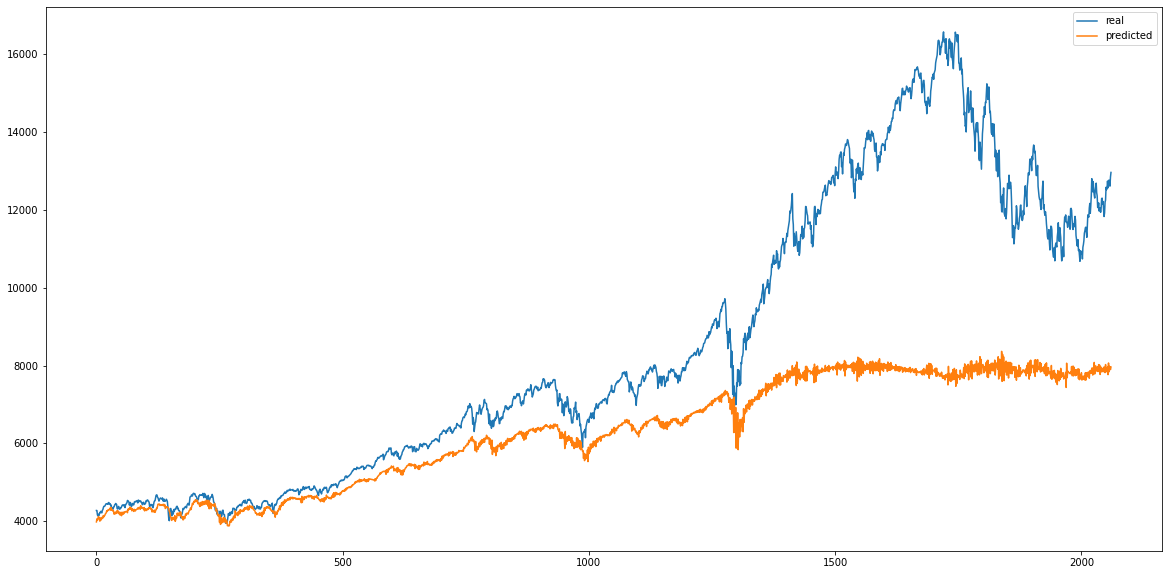

In [49]:
plt.plot(yvalid2, label = 'real')
plt.plot(y_pred2, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

In [39]:
print('RMSE model1: ' + str(my_rmse(y_pred1, scaler.inverse_transform(yvalid))))
print('RMSE model2: ' + str(my_rmse(y_pred2, scaler.inverse_transform(yvalid))))

RMSE model1: 12024.2538
RMSE model2: 4600.2626


In [111]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df_rnn, look_back = look_back, look_ahead = look_ahead)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)

In [112]:
def create_model3(out_dim):    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model3 = create_model3(out_dim = look_ahead)
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, None, 10)          120       
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
Total params: 440
Trainable params: 440
Non-trainable params: 0
_________________________________________________________________


In [113]:
model3.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

Epoch 1/6
313/313 [==============================] - 9s 21ms/step - loss: 0.0029 - val_loss: 0.1124
Epoch 2/6
313/313 [==============================] - 6s 20ms/step - loss: 1.5876e-04 - val_loss: 0.0840
Epoch 3/6
313/313 [==============================] - 6s 20ms/step - loss: 9.1651e-05 - val_loss: 0.0727
Epoch 4/6
313/313 [==============================] - 7s 24ms/step - loss: 6.9145e-05 - val_loss: 0.0643
Epoch 5/6
313/313 [==============================] - 8s 25ms/step - loss: 5.6287e-05 - val_loss: 0.0605
Epoch 6/6
313/313 [==============================] - 6s 20ms/step - loss: 5.0275e-05 - val_loss: 0.0561


In [114]:
y_pred3.shape

(2052, 1)

In [115]:
# predict and calculate RMSE
y_pred3 = model3.predict(xvalid)
y_pred3 = scaler.inverse_transform(y_pred3)
yvalid3 =  scaler.inverse_transform(yvalid)

In [116]:
y_pred3.shape, scaler.inverse_transform(yvalid).shape

((2052, 10), (2052, 10))

In [117]:
print('RMSE: ' + str(my_rmse(y_pred3, yvalid3)))

RMSE: 3830.9073


In [120]:
# plt.plot(yvalid3, label = 'real')
# plt.plot(y_pred3, label = 'predicted')
# plt.ylabel('')
# plt.legend()
# plt.show()

In [121]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df_rnn, look_back = look_back, look_ahead = look_ahead)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)

In [123]:
def create_model4(out_dim):
    
    model=Sequential()
    model.add(GRU(10,input_shape= [None,1], return_sequences = True))
    model.add(GRU(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model4 = create_model4(out_dim = look_ahead)
model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, None, 10)          390       
                                                                 
 gru_7 (GRU)                 (None, 10)                660       
                                                                 
 dense_9 (Dense)             (None, 10)                110       
                                                                 
Total params: 1,160
Trainable params: 1,160
Non-trainable params: 0
_________________________________________________________________


In [124]:
model4.fit(xtrain, 
           ytrain, 
           validation_data=(xvalid, yvalid), 
           epochs = CFG.nepochs, 
           batch_size = CFG.bsize, 
           callbacks=[ early_stop])

y_pred4 = model4.predict(xvalid)
y_pred4 = scaler.inverse_transform(y_pred4)
yvalid4 = scaler.inverse_transform(yvalid)

Epoch 1/6
313/313 [==============================] - 23s 53ms/step - loss: 0.0013 - val_loss: 0.0113
Epoch 2/6
313/313 [==============================] - 14s 46ms/step - loss: 3.9429e-05 - val_loss: 0.0114
Epoch 3/6
313/313 [==============================] - 14s 44ms/step - loss: 3.6215e-05 - val_loss: 0.0114
Epoch 4/6
313/313 [==============================] - 14s 45ms/step - loss: 3.4505e-05 - val_loss: 0.0118
Epoch 5/6
313/313 [==============================] - 17s 54ms/step - loss: 3.3510e-05 - val_loss: 0.0106
Epoch 6/6
313/313 [==============================] - 16s 50ms/step - loss: 3.3370e-05 - val_loss: 0.0097


In [126]:
y_pred4.shape, yvalid4.shape

((2052, 10), (2052, 10))

In [127]:
print('RMSE: ' + str(my_rmse(y_pred4, yvalid4)))

RMSE: 1595.3749


In [129]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df_rnn, look_back = look_back, look_ahead = look_ahead)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)

In [130]:
def create_model5(out_dim):    
    
    model=Sequential()
    model.add(LSTM(10,input_shape= [None,1], return_sequences = True))
    model.add(LSTM(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model5 = create_model5(out_dim = look_ahead)
model5.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 10)          480       
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
Total params: 1,430
Trainable params: 1,430
Non-trainable params: 0
_________________________________________________________________


In [131]:
model5.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred5 = model5.predict(xvalid)
y_pred5 = scaler.inverse_transform(y_pred5)

Epoch 1/6
313/313 [==============================] - 20s 45ms/step - loss: 0.0014 - val_loss: 0.0710
Epoch 2/6
313/313 [==============================] - 13s 40ms/step - loss: 8.6894e-05 - val_loss: 0.0575
Epoch 3/6
313/313 [==============================] - 13s 42ms/step - loss: 7.1806e-05 - val_loss: 0.0469
Epoch 4/6
313/313 [==============================] - 13s 42ms/step - loss: 6.3059e-05 - val_loss: 0.0361
Epoch 5/6
313/313 [==============================] - 13s 41ms/step - loss: 5.9632e-05 - val_loss: 0.0312
Epoch 6/6
313/313 [==============================] - 12s 40ms/step - loss: 5.3651e-05 - val_loss: 0.0287


In [135]:
yvalid5 = scaler.inverse_transform(yvalid)

In [136]:
print('RMSE RNN model1: ' + str(my_rmse(y_pred1, yvalid1)))
print('RMSE RNN model2: ' + str(my_rmse(y_pred2, yvalid2)))
print('RMSE RNN model3: ' + str(my_rmse(y_pred3, yvalid3)))
print('RMSE GRU: ' + str(my_rmse(y_pred4, yvalid4)))
print('RMSE LSTM: ' + str(my_rmse(y_pred5, yvalid5)))

RMSE RNN model1: 12024.2538
RMSE RNN model2: 3258.7694
RMSE RNN model3: 3830.9073
RMSE GRU: 1595.3749
RMSE LSTM: 2738.9131


In [75]:
# xtrain_small, xvalid_small = model_selection.train_test_split(nasdaq_ohlc_df[-1000:]['Close'].values, test_size = 300)

# pipe_small = pipeline.Pipeline([
#     ("fourier", ppc.FourierFeaturizer(m=250)),
#     ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
#                               seasonal=False,  # because we use Fourier
#                               suppress_warnings=True))
# ])

# pipe_small.fit(xtrain)

In [2]:
eur_data = pd.read_csv("./data/fx_data.csv")

In [3]:
eur_data.shape

(4993, 6)

In [4]:
eur_data

,Date,EURUSD_Open,EURUSD_High,EURUSD_Low,EURUSD_Close,EURUSD_Adj Close
0,2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501
1,2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897
2,2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298
3,2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094
4,2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695
...,...,...,...,...,...,...
4988,2023-02-22,1.065201,1.066553,1.061909,1.065201,1.065201
4989,2023-02-23,1.060580,1.063038,1.058201,1.060580,1.060580
4990,2023-02-24,1.059805,1.061425,1.053774,1.059805,1.059805
4991,2023-02-27,1.055476,1.061864,1.053352,1.055476,1.055476


In [5]:
msft = Ticker("msft")

In [6]:
msft.summary_detail

{'msft': {'maxAge': 1,
  'priceHint': 2,
  'previousClose': 251.11,
  'open': 252.19,
  'dayLow': 251.39,
  'dayHigh': 255.61,
  'regularMarketPreviousClose': 251.11,
  'regularMarketOpen': 252.19,
  'regularMarketDayLow': 251.39,
  'regularMarketDayHigh': 255.61,
  'dividendRate': 2.72,
  'dividendYield': 0.011,
  'exDividendDate': '2023-02-15 01:00:00',
  'payoutRatio': 0.28219998,
  'fiveYearAvgDividendYield': 1.13,
  'beta': 0.91562,
  'trailingPE': 27.39163,
  'forwardPE': 23.770018,
  'volume': 30740048,
  'regularMarketVolume': 30740048,
  'averageVolume': 31567738,
  'averageVolume10days': 26187390,
  'averageDailyVolume10Day': 26187390,
  'bid': 0.0,
  'ask': 0.0,
  'bidSize': 900,
  'askSize': 2200,
  'marketCap': 1900327731200,
  'fiftyTwoWeekLow': 213.43,
  'fiftyTwoWeekHigh': 315.95,
  'priceToSalesTrailing12Months': 9.311042,
  'fiftyDayAverage': 246.9602,
  'twoHundredDayAverage': 252.60335,
  'trailingAnnualDividendRate': 2.6,
  'trailingAnnualDividendYield': 0.01035402

In [7]:
s = Screener()
s.available_screeners

['advertising_agencies',
 'aerospace_defense',
 'aggressive_small_caps',
 'agricultural_inputs',
 'airlines',
 'airports_air_services',
 'all_cryptocurrencies_au',
 'all_cryptocurrencies_ca',
 'all_cryptocurrencies_eu',
 'all_cryptocurrencies_gb',
 'all_cryptocurrencies_in',
 'all_cryptocurrencies_us',
 'aluminum',
 'analyst_strong_buy_stocks',
 'apparel_manufacturing',
 'apparel_retail',
 'asset_management',
 'auto_manufacturers',
 'auto_parts',
 'auto_truck_dealerships',
 'banks_diversified',
 'banks_regional',
 'bearish_stocks_right_now',
 'best_hist_performance_etfs',
 'best_hist_performance_etfs_asia',
 'best_hist_performance_etfs_europe',
 'best_hist_performance_mutual_funds',
 'best_hist_performance_mutual_funds_asia',
 'best_hist_performance_mutual_funds_europe',
 'beverages_brewers',
 'beverages_non_alcoholic',
 'beverages_wineries_distilleries',
 'biotechnology',
 'bond_etfs',
 'bond_mutual_funds',
 'bond_mutual_funds_asia',
 'bond_mutual_funds_europe',
 'broadcasting',
 'bui

In [8]:
s.get_screeners(['most_actives', 'day_gainers'], 5)

{'most_actives': {'id': '437465ef-980e-4d8c-a860-de7cbfbab373',
  'title': 'Most Actives',
  'description': 'Discover the most traded equities in the trading day.',
  'canonicalName': 'MOST_ACTIVES',
  'criteriaMeta': {'size': 5,
   'offset': 0,
   'sortField': 'dayvolume',
   'sortType': 'DESC',
   'quoteType': 'EQUITY',
   'criteria': [{'field': 'region',
     'operators': ['EQ'],
     'values': [],
     'labelsSelected': [52],
     'dependentValues': []},
    {'field': 'intradaymarketcap',
     'operators': ['EQ'],
     'values': [],
     'labelsSelected': [1, 2, 3],
     'dependentValues': []},
    {'field': 'dayvolume',
     'operators': ['GT'],
     'values': [5000000],
     'labelsSelected': [],
     'dependentValues': []}],
   'topOperator': 'AND'},
  'rawCriteria': '{"offset":0,"size":5,"sortField":"dayvolume","sortType":"DESC","quoteType":"EQUITY","query":{"operator":"AND","operands":[{"operator":"eq","operands":["region","us"]},{"operator":"or","operands":[{"operator":"BTWN"

In [24]:
# Compare downloads for all companies within the S&P500
tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
sp500 = tables[0]['Symbol'].tolist()
sp500 = [symbol.replace(".", "-") for symbol in sp500]

In [35]:
%%time
tickers = Ticker(sp500, asynchronous=True)
yq_data = tickers.history(period='ytd', interval='1d')

type(yq_data)
yq_data.shape
yq_data.head()

Wall time: 11.2 s


open        high         low       close   volume  \
symbol date                                                                  
MMM    2023-01-03  121.519997  122.639999  120.370003  122.470001  2612800   
       2023-01-04  123.349998  125.290001  122.709999  125.150002  2769700   
       2023-01-05  124.209999  124.570000  122.459999  122.959999  2606600   
       2023-01-06  124.660004  127.129997  123.750000  126.720001  2417000   
       2023-01-09  127.000000  129.460007  126.110001  126.790001  2871300   

                     adjclose  dividends  splits  
symbol date                                       
MMM    2023-01-03  120.869644        0.0     0.0  
       2023-01-04  123.514618        0.0     0.0  
       2023-01-05  121.353233        0.0     0.0  
       2023-01-06  125.064102        0.0     0.0  
       2023-01-09  125.133186        0.0     0.0

In [36]:
yq_data.loc[('MMM')].index[:24]

Index([2023-01-03, 2023-01-04, 2023-01-05, 2023-01-06, 2023-01-09, 2023-01-10,
       2023-01-11, 2023-01-12, 2023-01-13, 2023-01-17, 2023-01-18, 2023-01-19,
       2023-01-20, 2023-01-23, 2023-01-24, 2023-01-25, 2023-01-26, 2023-01-27,
       2023-01-30, 2023-01-31, 2023-02-01, 2023-02-02, 2023-02-03, 2023-02-06],
      dtype='object', name='date')

The stationarity of a series can be checked by examining the distribution of the series: we split the series into 2 contiguous parts and compute the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary.

In [38]:
yq_data_MMM = yq_data.loc[('MMM')]

fig_MMM = go.Figure(data=[go.Candlestick(x=yq_data_MMM.index,
                open=yq_data_MMM['open'],
                high=yq_data_MMM['high'],
                low=yq_data_MMM['low'],
                close=yq_data_MMM['close'])])

fig_MMM.show()

In [46]:
x = (3.613)**10
x = x/100
x

3790.3526288714907